<hr style="border:8px solid red"> </hr>

# Start Recording

# Ensemble models

In this chapter we learn about ensemble modeling, which is a technique for training multiple ML algorithms (referred to as `base learners`) and combining their learning into one. Two very common ways of doing this are **bagging** and **boosting**.

## Reading and processing data

Let begin by reading our data. In this case, our data is already split into training and testing. How convenient!

In [1]:
import pandas as pd

df_train = pd.read_csv("adult_train.csv", sep = ",", header = 0)
df_test = pd.read_csv("adult_test.csv", sep = ",", skiprows = 2, names = df_train.columns)
print(df_train['Target'].value_counts(sort=True))
df_train.head()

 <=50K    24720
 >50K      7841
Name: Target, dtype: int64


,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Let's check our column types:

In [3]:
df_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

More Details:
https://archive.ics.uci.edu/ml/datasets/adult

Let's create a list of our categorical columns. Here keep every column whose data types is `object`, but we may need to narrow the list down even further.

In [2]:
cat_vars = df_train.select_dtypes('object').columns.to_list()
cat_vars

['Workclass',
 'Education',
 'Martial_Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Country',
 'Target']

In [3]:
cat_vars.pop() # removes `target=income` from cat_vars
cat_vars

['Workclass',
 'Education',
 'Martial_Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Country']

All of these columns look like they would be good candidates type `category`, but we covered that in a previous notebook and no need to return to that. We will take them as-is.

Let's drop any rows with missing data from the training and test sets. This is a very conservative approach and if we don't have a lot of data to begin with we may want to try a different approach such as imputing the missing values.

In [4]:
df_train = df_train.dropna(axis = 0)
df_test = df_test.dropna(axis = 0)

print('Train shape: {}'.format(df_train.shape))
print('Test shape: {}'.format(df_test.shape))

Train shape: (30162, 15)
Test shape: (15060, 15)


We now split the data into features and labels.

In [5]:
X_train = df_train.drop(columns = 'Target')
Y_train = df_train['Target']

X_test = df_test.drop(columns = 'Target')
Y_test = df_test['Target']

As part of data pre-processing, we need to one-hot-encode the categorical features. We already learned how to use `OneHotEncoder` in `sklearn.preprocessing`, but we will use another `OneHotEncoder` this time in the `category_encoders` library. It's important to know that `sklearn` is not the only library for ML in Python, so this will give us a change to try a new one. You should not be surprised to find out that the two have a lot in common, but also some slight additions that make things easier for us.

Before applying it to the data, let's create a very small train and test data with two rows and two columns and intentiall modify them slightly, just to learn how `OneHotEncoder` works.

In [6]:
import numpy as np

X_small_train = X_train.loc[2:3, ["Race", "Sex"]]
X_small_train.iloc[1, 1] = np.nan # introduce a nan to see what happens
X_small_train.head()

,Race,Sex
2,White,Male
3,Black,NaN


In [7]:
X_small_test = X_train.loc[4:5, ["Race", "Sex"]]
X_small_test.head()

,Race,Sex
4,Black,Female
5,White,Female


The `OneHotEncoder` class has two very important arguments called `handle_missing` and `handle_unknown` ethier of which can be set to `"error"`, `"return_nan"`, `"value"` or `"indicator"`.

In [33]:
import category_encoders as ce

handle = 'value' # options are: 'error', 'return_nan', 'value', and 'indicator'
onehoter =  ce.OneHotEncoder(return_df = True, 
                             cols = ["Race", "Sex"], 
                             drop_invariant = False,####
                             use_cat_names = True, 
                             handle_missing = handle, 
                             handle_unknown = handle)

<hr style="border:5px solid red"> </hr>

### Exercise

Let's examing the following settings and describe what happens when you run `onehoter.fit` on `X_small_train` and then run `onehoter.transform` on `X_small_train` and `X_small_test`.

- Set `handle = "indicator"` and `drop_invariant = False`.
- Set `handle = "error"`.
- Set `handle = "value"` and `drop_invariant = True`.
- Set `handle = "value"` and `drop_invariant = False`.
- Set `handle = "return_nan"` and `drop_invariant = True`.
- Set `handle = "return_nan"` and `drop_invariant = False`.

Which settings do you think are better in production? Why?

In [9]:
X_small_train.head()

,Race,Sex
2,White,Male
3,Black,NaN


In [10]:
X_small_test.head()

,Race,Sex
4,Black,Female
5,White,Female


In [34]:
onehoter.fit(X_small_train)
onehoter.transform(X_small_train)

,Race_ White,Race_ Black,Sex_ Male,Sex_nan
2,1,0,1,0
3,0,1,0,1


In [35]:
onehoter.transform(X_small_test)

,Race_ White,Race_ Black,Sex_ Male,Sex_nan
4,0,1,0,0
5,1,0,0,0


### End of exercise

Let's now run `OneHotEncoder` on the data. We create an instance of the class, which we call `onehoter`.

In [36]:
import category_encoders as ce

handle = "value" # options are: 'error', 'return_nan', 'value', and 'indicator'
onehoter =  ce.OneHotEncoder(return_df = True, 
                             cols = cat_vars, 
                             drop_invariant = False,
                             use_cat_names = True, 
                             handle_missing = handle, 
                             handle_unknown = handle)

Now we appy `onehoter` it to the training and test data.

In [37]:
onehoter.fit(X_train)
X_train_encoded = onehoter.transform(X_train)
X_test_encoded = onehoter.transform(X_test)

In [38]:
print("X_train shape = {}".format(X_train.shape))
print("X_train_encoded shape = {}".format(X_train_encoded.shape))

print("X_test shape = {}".format(X_test.shape))
print("X_test_encoded shape = {}".format(X_test_encoded.shape))

X_train shape = (30162, 14)
X_train_encoded shape = (30162, 104)
X_test shape = (15060, 14)
X_test_encoded shape = (15060, 104)


It might be a good idea to ensure that the training and test sets have the same number of columns before proceeding to the next step. This is one way to ensure that we have consistency between the two. We can use `assert` to do it.

In [40]:
assert X_train_encoded.shape[1] == X_test_encoded.shape[1], 'assertion failed'

We're now ready to train models on the one-hot-encoded data. Let's start with a random forest model. Notice that the `RandomForestClassifier` class below has several hyper-parameters such as `n_estimators`, `max_features`, `max_depth` and `min_leaf_size`. The latter two were inherited from the decision tree. For reasons that will become apparent later, we store these hyper-parameters in a dictionary called `hypers` and then pass them to the classifier. When we have a dictionary whose keys match a fuction's argument names, there is a neat functionality in Python that allows us to pass the dictionary to the function using `**` followed by the name of the dictionary. This saves us from having to type the argument names twice: once in the dictionary and once when calling the function.

<hr style="border:5px solid red"> </hr>

## Training a random forest classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

hypers = {"n_estimators": 500, "max_features": "sqrt", "max_depth": 20, "min_samples_leaf": 10}
clf_rf = RandomForestClassifier(random_state = 0, verbose = True, **hypers)

Let's now train the random forest classifier.

In [42]:
clf_rf.fit(X_train_encoded, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.5s finished


RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=10,
                       n_estimators=500, random_state=0, verbose=True)

If you see a message about using a sequential backend, it's because a random forest is an algorithm that can easily run in parallel by just training many trees concurrently. Since we don't have a large data set we don't need to bother with that here, but it's useful to know about this in case we need to speed up the training job.


> NOTE: in sklearn, each processor/thread needs duplicated data for itself. Here is a summary of reducing memory when parallelizing:

https://mljar.com/blog/random-forest-memory/

One by product of tree-based models is that they provide us with a list showing the relative importance of each feature to the model. So even if we're not interested in the trained model the random forest returns, we can still use it for **feature selection**: namely train the random forest on the whole data to get the top $n$ most important features and later pass only those features to another algorithm we wish to use to train a model. Note that because we one-hot-encoded the data, a feature here is not just one of the categorical columns, but each category of each categorical column is its own feature. We can find the feature importance values in `clf_rf.feature_importances_`.

In [43]:
len(clf_rf.feature_importances_)

104

Let's store the feature importance values in a `DataFrame` and use `seaborn` to visualize the top 10.

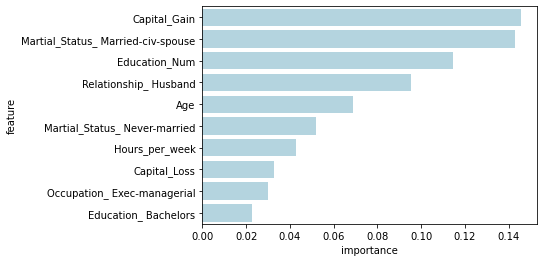

In [44]:
df_var_imp = pd.DataFrame({"feature": X_train_encoded.columns, 
                           "importance": clf_rf.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

import seaborn as sns
ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp.head(10), color = "lightblue")

To get predictions from the trained model, we simply call the `predict` method and pass it the data. To check if we're overfitting or not, we can get predictions for both the training and the test data. Once we have the predictions, we can call the `accuracy_score` function to get the accuracy on the training and test data, assuming that accuracy is a good metric to use here.

We're already written the code there for you. But there's a problem with it. Your job is to run it and see if you can debug it.

In [45]:
Y_hat_train = clf_rf.predict(X_train_encoded)
Y_hat_test = clf_rf.predict(X_test_encoded)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.1s finished


In [46]:
Y_train.head()

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: Target, dtype: object

In [47]:
Y_test.head()

0     <=50K.
1     <=50K.
2      >50K.
3      >50K.
5     <=50K.
Name: Target, dtype: object

There is a slight discrepancy between the labels as they show up in the training data and the test data: the labels in the test data end with a period. So we need to remove the period when we evaluate the model. We do so using `.str.replace("\\.$", "")` in the cell below, where `"\\.$"` is a regular expression that searches for a period at the end of a string.

In [48]:
from sklearn.metrics import accuracy_score
acc_train = accuracy_score(Y_train, Y_hat_train)

end_of_line_period_regex = r'\.$'

acc_test = accuracy_score(Y_test.str.replace(end_of_line_period_regex, ""), Y_hat_test)

print('Train set accuracy: {:.2f}%'.format(acc_train * 100))
print('Test set accuracy: {:.2f}%'.format(acc_test * 100))

Train set accuracy: 86.35%
Test set accuracy: 85.76%


We will be storing some important results in a table we call `results`. If this table doesn't exist (first time we run it) it will initialized by the code below.

In [49]:
try:
    results # checks if this object exists or not
except NameError:
    results = pd.DataFrame(columns = ["algo", "acc_train", "acc_test"]) # initiates it

Every row of the table will store accuracy metrics for one training iteration given one set of hyper-parameters (also listed in the table).

In [50]:
# Create metrics:
print(clf_rf.__class__)

model_name = str(clf_rf.__class__).split('.')[-1].strip("\"\'>")

print('Changed to {}'.format(model_name))



results.loc[len(results), 0:3] = [model_name, acc_train, acc_test]

print('\n-Hyperparameters:')
for hp in hypers.keys():
    print(hypers[hp])
    results.loc[len(results) - 1, hp] = hypers[hp]

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Changed to RandomForestClassifier

-Hyperparameters:
500
sqrt
20
10


In [51]:
results

,algo,acc_train,acc_test,n_estimators,max_features,max_depth,min_samples_leaf
0,RandomForestClassifier,0.863504,0.85757,500.0,sqrt,20.0,10.0


We can now go back up to where we trained the random forest classifier and change its hyper-parameters, retrain it, re-evaluate it, and finally store the results as a new row in the `results` table. This way we can compare our different runs.

In [52]:
hypers = [{"n_estimators": 100, "max_features": "sqrt", "max_depth": 5, "min_samples_leaf": 10},
          {"n_estimators": 100, "max_features": "sqrt", "max_depth": 7, "min_samples_leaf": 15},
          {"n_estimators": 100, "max_features": "sqrt", "max_depth": 9, "min_samples_leaf": 20}]

model_dict = {'clf_rf1': RandomForestClassifier(random_state = 0, verbose = True, **hypers[0]),
              'clf_rf2': RandomForestClassifier(random_state = 0, verbose = True, **hypers[1]),
              'clf_rf3': RandomForestClassifier(random_state = 0, verbose = True, **hypers[2])}


for model_ix, (model_name, model_fun) in enumerate(model_dict.items()):
    print('Training Model:{}'.format(model_name))
    # Train model
    model_fun.fit(X_train_encoded, Y_train)

    # Get predictions
    Y_hat_train = model_fun.predict(X_train_encoded)
    Y_hat_test = model_fun.predict(X_test_encoded)

    # Compute Accuracies
    acc_train = accuracy_score(Y_train, Y_hat_train)
    acc_test = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test)

    try:
        results # checks if this object exists or not
    except NameError:
        results = pd.DataFrame(columns = ["algo", "acc_train", "acc_test"])

    results.loc[len(results), 0:3] = [model_name, acc_train, acc_test]

    for hp in hypers[model_ix].keys():
        results.loc[len(results) - 1, hp] = hypers[model_ix][hp]

Training Model:clf_rf1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training Model:clf_rf2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training Model:clf_rf3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Let's see what we end up with:

In [53]:
results

,algo,acc_train,acc_test,n_estimators,max_features,max_depth,min_samples_leaf
0,RandomForestClassifier,0.863504,0.85757,500.0,sqrt,20.0,10.0
1,clf_rf1,0.835754,0.832935,100.0,sqrt,5.0,10.0
2,clf_rf2,0.84381,0.841965,100.0,sqrt,7.0,15.0
3,clf_rf3,0.850209,0.847078,100.0,sqrt,9.0,20.0


<hr style="border:5px solid red"> </hr>

## Training a gradient boosted classifier

Let's now train a gradient boosted classifier. Shrinkage is controlled by `learning_rate`.

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

hypers = {"n_estimators": 10, "max_features": "sqrt", "max_depth": 20, "min_samples_leaf": 10, "learning_rate": 0.5}
clf_gb = GradientBoostingClassifier(loss = 'deviance', verbose = True, **hypers)

One again we train the classifier by calling `fit`.

In [55]:
clf_gb.fit(X_train_encoded, Y_train)

      Iter       Train Loss   Remaining Time 
         1           0.8050            0.77s
         2           0.7006            0.68s
         3           0.6301            0.61s
         4           0.5860            0.53s
         5           0.5530            0.45s
         6           0.5301            0.35s
         7           0.5095            0.26s
         8           0.4921            0.17s
         9           0.4751            0.09s
        10           0.4665            0.00s


GradientBoostingClassifier(learning_rate=0.5, max_depth=20, max_features='sqrt',
                           min_samples_leaf=10, n_estimators=10, verbose=True)

We can display the variable importance plot for a gradient boosted classifier as well. The results should not look very different from using random forests.

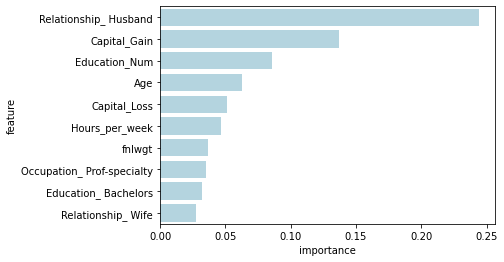

In [56]:
df_var_imp = pd.DataFrame({"feature": X_train_encoded.columns, 
                           "importance": clf_gb.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

import seaborn as sns
ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp.head(10), color = "lightblue")

We now score the training and test sets with the trained model from the previous step.

In [57]:
Y_hat_train = clf_gb.predict(X_train_encoded)
Y_hat_test = clf_gb.predict(X_test_encoded)

We obtain the accuracy scores in either case.

In [58]:
acc_train = accuracy_score(Y_train, Y_hat_train)
acc_test = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test)

print('Train set accuracy: {:.2f}%'.format(acc_train * 100))
print('Test set accuracy: {:.2f}%'.format(acc_test * 100))

Train set accuracy: 89.49%
Test set accuracy: 85.72%


And we store the results in the same `results` table as bofere.

In [59]:
model_name = str(clf_gb.__class__).split('.')[-1].strip("\"\'>")
results.loc[len(results), 0:3] = [model_name, acc_train, acc_test]

for hp in hypers.keys():
    results.loc[len(results) - 1, hp] = hypers[hp]

In [60]:
results

,algo,acc_train,acc_test,n_estimators,max_features,max_depth,min_samples_leaf,learning_rate
0,RandomForestClassifier,0.863504,0.85757,500.0,sqrt,20.0,10.0,NaN
1,clf_rf1,0.835754,0.832935,100.0,sqrt,5.0,10.0,NaN
2,clf_rf2,0.84381,0.841965,100.0,sqrt,7.0,15.0,NaN
3,clf_rf3,0.850209,0.847078,100.0,sqrt,9.0,20.0,NaN
4,GradientBoostingClassifier,0.894901,0.857238,10.0,sqrt,20.0,10.0,0.5


<hr style="border:5px solid red"> </hr>

### Exercise

Return to the two classifiers we trained above and change the hyper-parametrs and train at least 10 different random forest and 10 different gradient boosted classfiers. Make sure to store all the training runs in the `results` table. Once you have all the runs, find the best model you have and report its accuracy and state your choice of hyper-parametrs. We will compare this with everyone else in class to see who got the best model.

Before you begin, recall that bagged learners like random forests reduce variance, so we want their **base-learner** to be more likely overfit (**high variance**). On the other hand, boosted learners like gradient boosted trees reduce bias, so we want their **base-learners** to be more likely to underfit (**high bias**). So your choice of hyper-parameters for the base-learners (decision trees) in each case should reflect this tendency.

To make it easy, we're already pasted the cells for you here. You will train 10 different **random forests**.

In [62]:
hypers = [{"n_estimators": 300, "max_features": "sqrt", "max_depth": 5, "min_samples_leaf": 10},
          {"n_estimators": 300, "max_features": "sqrt", "max_depth": 7, "min_samples_leaf": 15},
          {"n_estimators": 300, "max_features": "sqrt", "max_depth": 9, "min_samples_leaf": 20},
          {"n_estimators": 300, "max_features": "sqrt", "max_depth": 3, "min_samples_leaf": 20},
          {"n_estimators": 300, "max_features": "sqrt", "max_depth": 11, "min_samples_leaf": 10},
         {"n_estimators": 10, "max_features": "sqrt", "max_depth": 10, "min_samples_leaf": 10, "learning_rate": 0.1},
         {"n_estimators": 10, "max_features": "sqrt", "max_depth": 20, "min_samples_leaf": 10, "learning_rate": 0.1},
         {"n_estimators": 10, "max_features": "sqrt", "max_depth": 30, "min_samples_leaf": 10, "learning_rate": 0.1},
         {"n_estimators": 10, "max_features": "sqrt", "max_depth": 10, "min_samples_leaf": 10, "learning_rate": 0.5},
         {"n_estimators": 10, "max_features": "sqrt", "max_depth": 30, "min_samples_leaf": 10, "learning_rate": 0.5}]


model_dict = {'clf_rf4': RandomForestClassifier(random_state = 0, verbose = True, **hypers[0]),
              'clf_rf5': RandomForestClassifier(random_state = 0, verbose = True, **hypers[1]),
              'clf_rf6': RandomForestClassifier(random_state = 0, verbose = True, **hypers[2]),
              'clf_rf7': RandomForestClassifier(random_state = 0, verbose = True, **hypers[3]),
              'clf_rf8': RandomForestClassifier(random_state = 0, verbose = True, **hypers[4]), 
              'clf_gb1': GradientBoostingClassifier(loss = 'deviance', verbose = True, **hypers[5]),
             'clf_gb2': GradientBoostingClassifier(loss = 'deviance', verbose = True, **hypers[6]),
             'clf_gb3': GradientBoostingClassifier(loss = 'deviance', verbose = True, **hypers[7]),
             'clf_gb4': GradientBoostingClassifier(loss = 'deviance', verbose = True, **hypers[8]),
             'clf_gb5': GradientBoostingClassifier(loss = 'deviance', verbose = True, **hypers[9])}


for model_ix, (model_name, model_fun) in enumerate(model_dict.items()):
    print('Training Model:{}'.format(model_name))
    # Train model
    model_fun.fit(X_train_encoded, Y_train)

    # Get predictions
    Y_hat_train = model_fun.predict(X_train_encoded)
    Y_hat_test = model_fun.predict(X_test_encoded)

    # Compute Accuracies
    acc_train = accuracy_score(Y_train, Y_hat_train)
    acc_test = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test)

    try:
        results # checks if this object exists or not
    except NameError:
        results = pd.DataFrame(columns = ["algo", "acc_train", "acc_test"]) # initiates it

    results.loc[len(results), 0:3] = [model_name, acc_train, acc_test]

    for hp in hypers[model_ix].keys():
        results.loc[len(results) - 1, hp] = hypers[model_ix][hp]

Training Model:clf_rf4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished


Training Model:clf_rf5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished


Training Model:clf_rf6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished


Training Model:clf_rf7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished


Training Model:clf_rf8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished


Training Model:clf_gb1
      Iter       Train Loss   Remaining Time 
         1           1.0460            0.35s
         2           0.9845            0.35s
         3           0.9429            0.31s
         4           0.9002            0.26s
         5           0.8639            0.22s
         6           0.8347            0.17s
         7           0.8073            0.13s
         8           0.7836            0.09s
         9           0.7647            0.04s
        10           0.7449            0.00s
Training Model:clf_gb2
      Iter       Train Loss   Remaining Time 
         1           1.0341            0.74s
         2           0.9680            0.65s
         3           0.9148            0.57s
         4           0.8700            0.50s
         5           0.8325            0.42s
         6           0.8002            0.33s
         7           0.7710            0.25s
         8           0.7451            0.17s
         9           0.7222            0.08s
       

In [63]:
results

,algo,acc_train,acc_test,n_estimators,max_features,max_depth,min_samples_leaf,learning_rate
0,RandomForestClassifier,0.863504,0.85757,500.0,sqrt,20.0,10.0,NaN
1,clf_rf1,0.835754,0.832935,100.0,sqrt,5.0,10.0,NaN
2,clf_rf2,0.84381,0.841965,100.0,sqrt,7.0,15.0,NaN
3,clf_rf3,0.850209,0.847078,100.0,sqrt,9.0,20.0,NaN
4,GradientBoostingClassifier,0.894901,0.857238,10.0,sqrt,20.0,10.0,0.5
5,clf_rf4,0.835588,0.832072,300.0,sqrt,5.0,10.0,NaN
6,clf_rf5,0.843744,0.841899,300.0,sqrt,7.0,15.0,NaN
7,clf_rf6,0.850507,0.847078,300.0,sqrt,9.0,20.0,NaN
8,clf_rf7,0.793714,0.795418,300.0,sqrt,3.0,20.0,NaN
9,clf_rf8,0.856574,0.852191,300.0,sqrt,11.0,10.0,NaN


<hr style="border:5px solid red"> </hr>

## Early Stopping w/ GBM

It is easy to overfit with `GradientBoostingClassifier`, because as we saw boosting tries to model the residual error, and iteration after iteration the error we are left with contains less and less signal and more and more noise. To that end, it is useful to implement what's called **early stopping**:

- we set aside a validation data
- as we train the base classifier at each iteration, we predict on the validation data and compute the error
- if validation error doesn't improve **after a certain number of iterations by at least a certain percentage** (called the **tolerance**), we stop the trainig

In `GradientBoostingClassifier` early stopping can be implemented using the `validation_fraction`, `n_iter_no_change` and `tol` arguments. You can read [the documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html) for more details on this.

Run one more run of `GradientBoostingClassifier` and this time implement early stopping. After training, you can check the number of iterations that were run by running `model.n_estimators_`. Normally this is just the number of iterations you chose to run, but if early stopping is implemented then it can be a smaller number.

When you're done with your runs, you can check all the results by running the next cell.

In [66]:
hypers_w_early_stop = {"n_estimators": 100, "max_features": "sqrt", "max_depth": 20, "min_samples_leaf": 10,
                       "learning_rate": 0.5, "validation_fraction": 0.20, "n_iter_no_change": 3, "tol": 0.01}

clf_gb_stop = GradientBoostingClassifier(loss = 'deviance', verbose = True, **hypers_w_early_stop)

clf_gb_stop.fit(X_train_encoded, Y_train)

# Accuracies
Y_hat_train = clf_gb_stop.predict(X_train_encoded)
Y_hat_test = clf_gb_stop.predict(X_test_encoded)

acc_train = accuracy_score(Y_train, Y_hat_train)
acc_test = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test)

print('Train set accuracy: {:.2f}%'.format(acc_train * 100))
print('Test set accuracy: {:.2f}%'.format(acc_test * 100))

      Iter       Train Loss   Remaining Time 
         1           0.8052            6.38s
         2           0.6859            6.61s
         3           0.6197            6.95s
         4           0.5771            7.03s
         5           0.5420            7.03s
         6           0.5172            7.02s
         7           0.4948            7.07s
         8           0.4791            6.80s
         9           0.4647            6.70s
Train set accuracy: 88.79%
Test set accuracy: 85.71%


Add this to the result frame:

In [68]:
model_name = str(clf_gb_stop.__class__).split('.')[-1].strip("\"\'>")
results.loc[len(results), 0:3] = [model_name, acc_train, acc_test]

for hp in hypers_w_early_stop.keys():
    results.loc[len(results) - 1, hp] = hypers_w_early_stop[hp]

In [69]:
results

,algo,acc_train,acc_test,n_estimators,max_features,max_depth,min_samples_leaf,learning_rate,validation_fraction,n_iter_no_change,tol
0,RandomForestClassifier,0.863504,0.85757,500.0,sqrt,20.0,10.0,NaN,NaN,NaN,NaN
1,clf_rf1,0.835754,0.832935,100.0,sqrt,5.0,10.0,NaN,NaN,NaN,NaN
2,clf_rf2,0.84381,0.841965,100.0,sqrt,7.0,15.0,NaN,NaN,NaN,NaN
3,clf_rf3,0.850209,0.847078,100.0,sqrt,9.0,20.0,NaN,NaN,NaN,NaN
4,GradientBoostingClassifier,0.894901,0.857238,10.0,sqrt,20.0,10.0,0.5,NaN,NaN,NaN
5,clf_rf4,0.835588,0.832072,300.0,sqrt,5.0,10.0,NaN,NaN,NaN,NaN
6,clf_rf5,0.843744,0.841899,300.0,sqrt,7.0,15.0,NaN,NaN,NaN,NaN
7,clf_rf6,0.850507,0.847078,300.0,sqrt,9.0,20.0,NaN,NaN,NaN,NaN
8,clf_rf7,0.793714,0.795418,300.0,sqrt,3.0,20.0,NaN,NaN,NaN,NaN
9,clf_rf8,0.856574,0.852191,300.0,sqrt,11.0,10.0,NaN,NaN,NaN,NaN


Make sure that you check the classifier's documentation and understand what `n_estimators`, `max_features`, `max_depth`, and `min_leaf_size` represent. Then, answer the following question:

- What seems to be the effect of changing each of these hyper-parameters on the accuracy of the training and test data?
- Does this match your intuition about how these hyper-parameters work?
- Are there any hyper-parameters that seem promising and worth trying to tune?

### End of exercise

Hyper-parameter tuning can be a very time-consuming and difficult task. In a future lecture, we will see how we can use a Python library to automatically specify different hyper-parameter values ahead of time and train different models. This will save us from having to manually re-run external scripts or collect results, but for now this will suffice and it's also a chance to show-case some more advanced Python and Jupyter functionality.

<hr style="border:5px solid red"> </hr>

## Visually Overfitting

Let's compare how overfitting behaves between GBM and Random Forest models.

In [70]:
import matplotlib.pyplot as plt
n_estimators = [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]

rf_train_acc = []
rf_test_acc = []
gbm_train_acc = []
gbm_test_acc = []
gbms_train_acc = []
gbms_test_acc = []

for n in n_estimators:
    print('Fitting models for n={}. Please wait.'.format(n))
    rf_hypers = {"n_estimators": n, "max_features": "sqrt", "max_depth": 10, "min_samples_leaf": 10}
    gbm_hypers = {"n_estimators": n, "max_features": "sqrt", "max_depth": 10, "min_samples_leaf": 10,
                  "learning_rate": 0.5}
    gbm_stop_hypers = {"n_estimators": n, "max_features": "sqrt", "max_depth": 10, "min_samples_leaf": 10,
                       "learning_rate": 0.5, "validation_fraction": 0.20, "n_iter_no_change": 3, "tol": 0.01}
    
    # Setup Models
    rf_model = RandomForestClassifier(random_state = 0, verbose = False, **rf_hypers)
    gbm_model = GradientBoostingClassifier(loss = 'deviance', verbose = False, **gbm_hypers)
    gbm_stop_model = GradientBoostingClassifier(loss = 'deviance', verbose = False, **gbm_stop_hypers)
    
    # Fit models
    rf_model.fit(X_train_encoded, Y_train)
    gbm_model.fit(X_train_encoded, Y_train)
    gbm_stop_model.fit(X_train_encoded, Y_train)
    
    # Get accuracies
    Y_hat_train_rf = rf_model.predict(X_train_encoded)
    Y_hat_test_rf = rf_model.predict(X_test_encoded)
    Y_hat_train_gbm = gbm_model.predict(X_train_encoded)
    Y_hat_test_gbm = gbm_model.predict(X_test_encoded)
    Y_hat_train_gbms = gbm_stop_model.predict(X_train_encoded)
    Y_hat_test_gbms = gbm_stop_model.predict(X_test_encoded)

    acc_train_rf = accuracy_score(Y_train, Y_hat_train_rf)
    acc_test_rf = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test_rf)
    acc_train_gbm = accuracy_score(Y_train, Y_hat_train_gbm)
    acc_test_gbm = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test_gbm)
    acc_train_gbms = accuracy_score(Y_train, Y_hat_train_gbms)
    acc_test_gbms = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test_gbms)
    
    # Save outputs
    rf_train_acc.append(acc_train_rf)
    rf_test_acc.append(acc_test_rf)
    gbm_train_acc.append(acc_train_gbm)
    gbm_test_acc.append(acc_test_gbm)
    gbms_train_acc.append(acc_train_gbms)
    gbms_test_acc.append(acc_test_gbms)

Fitting models for n=2. Please wait.
Fitting models for n=3. Please wait.
Fitting models for n=4. Please wait.
Fitting models for n=5. Please wait.
Fitting models for n=10. Please wait.
Fitting models for n=15. Please wait.
Fitting models for n=20. Please wait.
Fitting models for n=25. Please wait.
Fitting models for n=30. Please wait.
Fitting models for n=40. Please wait.
Fitting models for n=50. Please wait.


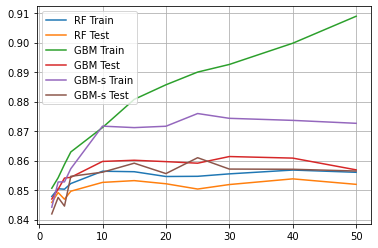

In [71]:
# Plot outputs
plt.plot(n_estimators, rf_train_acc, label='RF Train')
plt.plot(n_estimators, rf_test_acc, label='RF Test')
plt.plot(n_estimators, gbm_train_acc, label='GBM Train')
plt.plot(n_estimators, gbm_test_acc, label='GBM Test')
plt.plot(n_estimators, gbms_train_acc, label='GBM-s Train')
plt.plot(n_estimators, gbms_test_acc, label='GBM-s Test')
plt.grid()
plt.legend()

<hr style="border:5px solid red"> </hr>

## Training a non-tree-based ensemble model

We finish this notebook by providing an example of a non-tree-based classifier. Tree-based classifiers are so common that they have their own functions in `sklearn`, but if we want we can choose any base-learners and pass it to the `BaggingClassifier` or any of the other ensemble learners in `sklearn.ensemble`. In the following example, we use `KNeighborsClassifier` as the base learner and train a bagged classifier.

In [72]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

bag_cls = BaggingClassifier(KNeighborsClassifier(), max_samples = 0.5, max_features = 0.5)
bag_cls.fit(X_train_encoded, Y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(), max_features=0.5,
                  max_samples=0.5)

We can let the classifier predict on the training and test data.

While it's computing, read over the documentation here:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [73]:
# May take a minute to compute
Y_hat_train = bag_cls.predict(X_train_encoded)
Y_hat_test = bag_cls.predict(X_test_encoded)

And obtain just as before.

In [74]:
acc_train = accuracy_score(Y_train, Y_hat_train)
acc_test = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test)

print("Accuracy on training data = {:.03f} and on test data = {:.03f}".format(acc_train, acc_test))

Accuracy on training data = 0.865 and on test data = 0.833


So ensemble classifiers are a great method to improve accuracy if we're willing to pay the computational cost. Another downside as we saw in this notebook is that we add new hyper-parameters on top of the ones we inherit from the base learner and hyper-parameter tuning becomes a daunting task. In fact, one of the short-comings in this notebook is that we did our hyper-parameter tuning on the **test data** when we should have used a **validation data** instead. If we try a few different runs we can get away with this, but if we get serious about hyper-parameter tuning then as we learned the right way to do it is to evaluate the hyper-parameters on the **validation data** (or to use cross-validation) and leave the **test data** to evaluate the accuracy of the **final model** at the end.